In [153]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
sent = pd.read_csv("/content/drive/MyDrive/Copy of fear_greed_index.csv", parse_dates=["date"])

trades = pd.read_csv("/content/drive/MyDrive/Copy of historical_data.csv", parse_dates=["Timestamp IST"])

print(sent.head())
print(trades.head())


    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     10

In [155]:
sent.columns = sent.columns.str.strip()
trades.columns = trades.columns.str.strip()


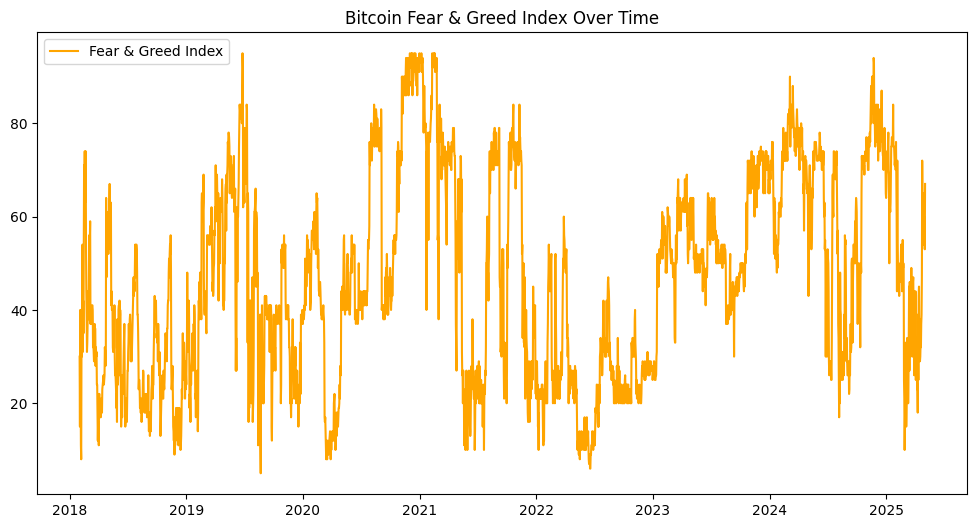

In [156]:
sent = sent.rename(columns={"value": "sentiment_value", "classification": "sentiment_class"})

plt.figure(figsize=(12,6))
plt.plot(sent['date'], sent['sentiment_value'], label="Fear & Greed Index", color="orange")
plt.legend()
plt.title("Bitcoin Fear & Greed Index Over Time")
plt.show()


In [157]:
sent['date'] = pd.to_datetime(sent['date']).dt.date
trades['date'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True).dt.date

merged = trades.merge(sent[['date','sentiment_value','sentiment_class']], on='date', how='left')

print(merged.head())


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [158]:
print(trades.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date']


In [159]:
print(merged.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'sentiment_value', 'sentiment_class'],
      dtype='object')


In [160]:
merged['notional'] = merged['Execution Price'] * merged['Size Tokens']
merged['return'] = merged['Closed PnL'] / merged['notional'].replace(0, pd.NA)
merged['is_win'] = (merged['Closed PnL'] > 0).astype(int)


In [161]:
merged['leverage'] = merged['notional'] / merged['Start Position']


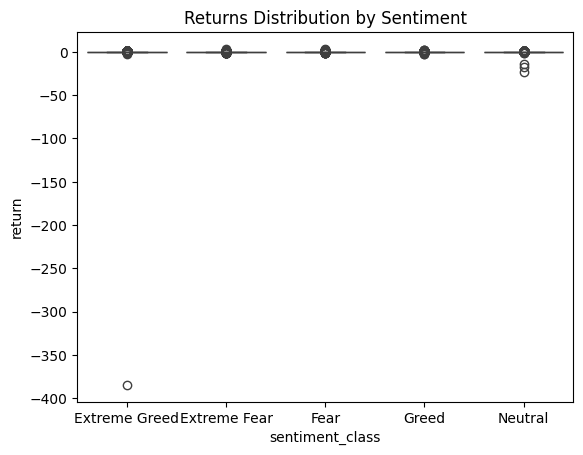

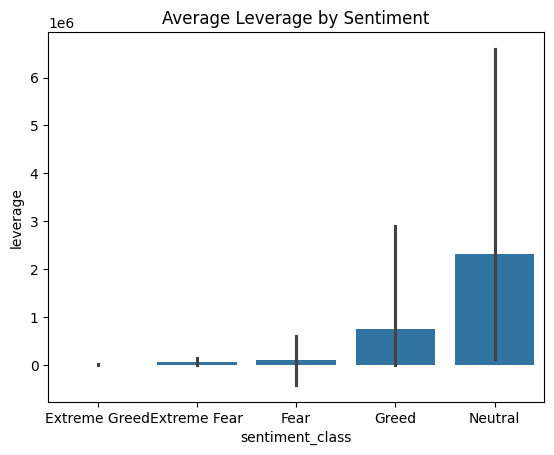

Mean PnL by Sentiment:
 sentiment_class
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64
Win Rate by Sentiment:
 sentiment_class
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: is_win, dtype: float64


In [162]:
sns.boxplot(x='sentiment_class', y='return', data=merged)
plt.title("Returns Distribution by Sentiment")
plt.show()

sns.barplot(x='sentiment_class', y='leverage', data=merged)
plt.title("Average Leverage by Sentiment")
plt.show()

print("Mean PnL by Sentiment:\n", merged.groupby('sentiment_class')['Closed PnL'].mean())
print("Win Rate by Sentiment:\n", merged.groupby('sentiment_class')['is_win'].mean())


In [163]:
print(merged[['notional', 'Start Position', 'leverage']].describe())


           notional  Start Position      leverage
count  2.112240e+05    2.112240e+05  2.112240e+05
mean   5.639451e+03   -2.994625e+04           inf
std    3.657514e+04    6.738074e+05           NaN
min    1.627190e-07   -1.433463e+07 -1.045050e+10
25%    1.937895e+02   -3.762311e+02 -2.710024e-02
50%    5.970446e+02    8.472793e+01  1.355906e-02
75%    2.058961e+03    9.337278e+03  6.391973e-01
max    3.921431e+06    3.050948e+07           inf


In [164]:
merged = merged[merged['Start Position'] != 0]

merged['leverage'] = merged['leverage'].clip(upper=50)


In [165]:
import numpy as np

merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['leverage'])


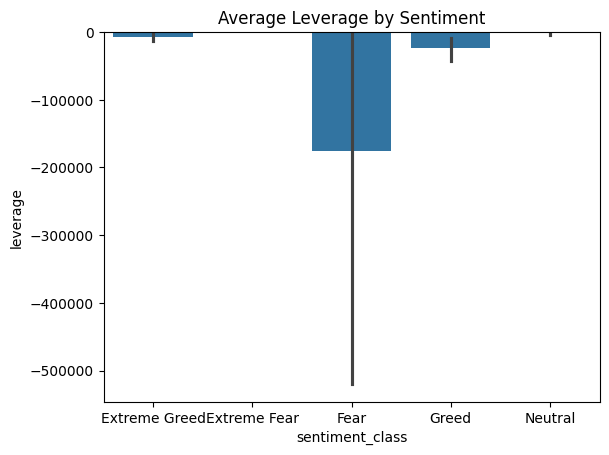

In [166]:

sns.barplot(x='sentiment_class', y='leverage', data=merged)
plt.title("Average Leverage by Sentiment")
plt.show()


In [167]:
merged = merged[merged['Start Position'] != 0]

merged['leverage'] = merged['notional'] / merged['Start Position']

merged['leverage'].replace([np.inf, -np.inf], np.nan, inplace=True)
merged.dropna(subset=['leverage'], inplace=True)

merged['leverage'] = merged['leverage'].clip(upper=50)


/tmp/ipython-input-1287965460.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['leverage'].replace([np.inf, -np.inf], np.nan, inplace=True)


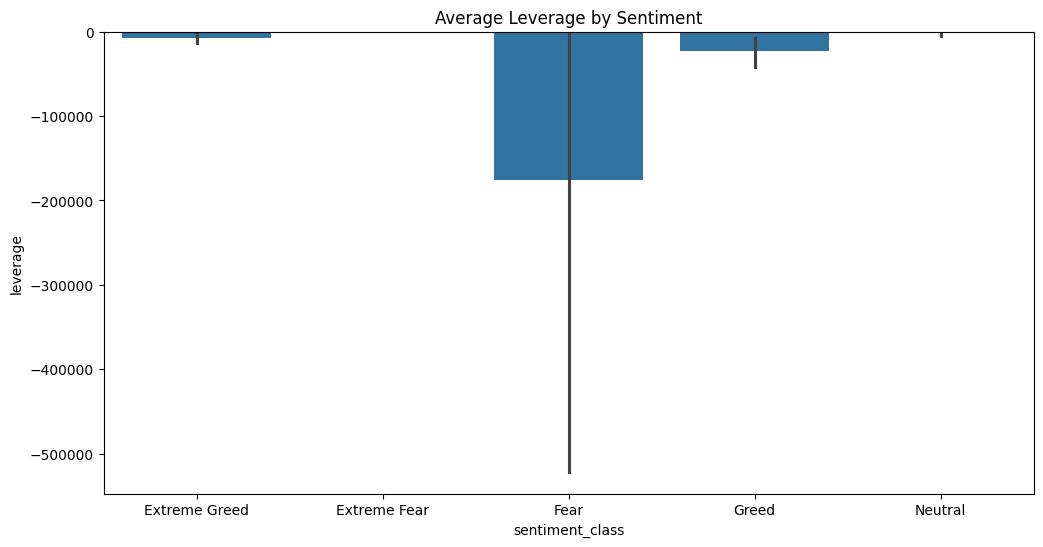

In [168]:
plt.figure(figsize=(12,6))
sns.barplot(x='sentiment_class', y='leverage', data=merged)
plt.title("Average Leverage by Sentiment")
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


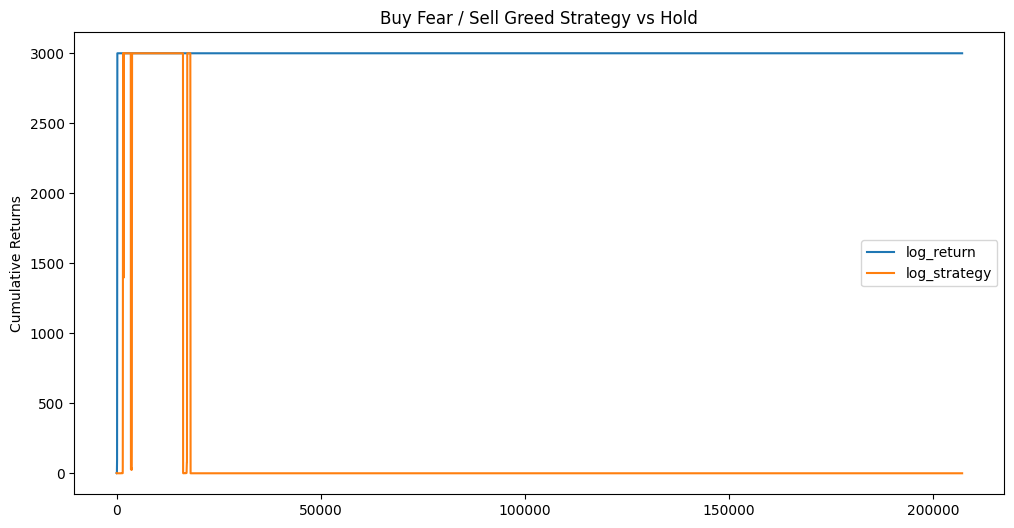

In [172]:

os.makedirs("/content/drive/MyDrive/ds_devpratap/csv_files", exist_ok=True)
os.makedirs("/content/drive/MyDrive/ds_devpratap/outputs", exist_ok=True)


merged['position'] = 0
merged.loc[merged['sentiment_value'] < 30, 'position'] = 1
merged.loc[merged['sentiment_value'] > 70, 'position'] = -1


merged['strategy_return'] = merged['position'].shift(1) * merged['return']


merged['return_clipped'] = merged['return'].clip(-0.2, 0.2)
merged['strategy_return_clipped'] = merged['strategy_return'].clip(-0.2, 0.2)

merged.replace([np.inf, -np.inf], np.nan, inplace=True)
merged.dropna(subset=['return_clipped','strategy_return_clipped'], inplace=True)


merged['log_return'] = np.log1p(merged['return_clipped'])
merged['log_strategy'] = np.log1p(merged['strategy_return_clipped'])

cumulative = np.exp(merged[['log_return','log_strategy']].cumsum())


cumulative = cumulative.reset_index(drop=True)


cumulative = cumulative.clip(upper=3000)


fig, ax = plt.subplots(figsize=(12,6))
cumulative.plot(ax=ax)
ax.set_title("Buy Fear / Sell Greed Strategy vs Hold")
ax.set_ylabel("Cumulative Returns")


fig.savefig("/content/drive/MyDrive/ds_devpratap/outputs/strategy_plot.png", bbox_inches='tight')
plt.show()

merged.to_csv("/content/drive/MyDrive/ds_devpratap/csv_files/merged_data.csv", index=False)


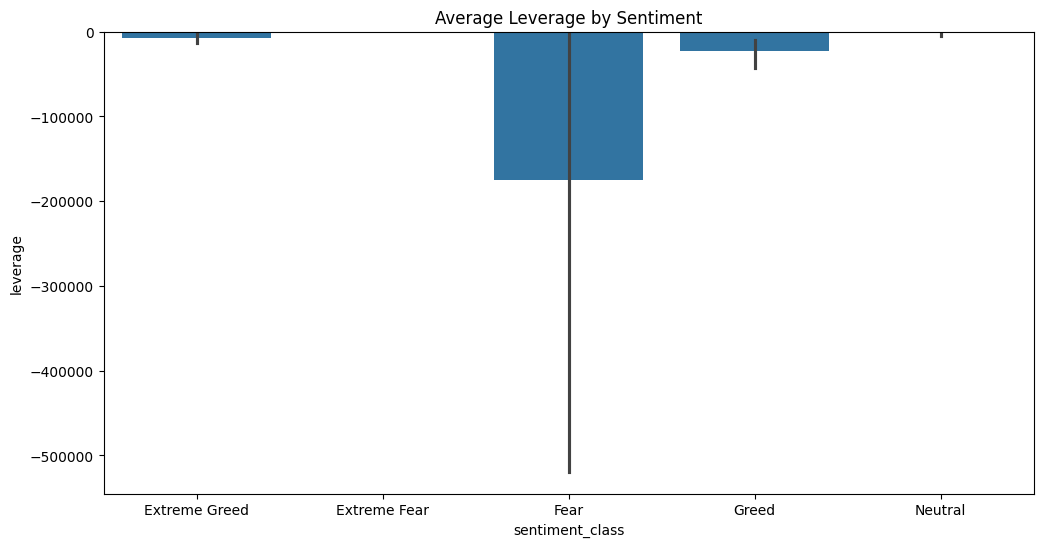

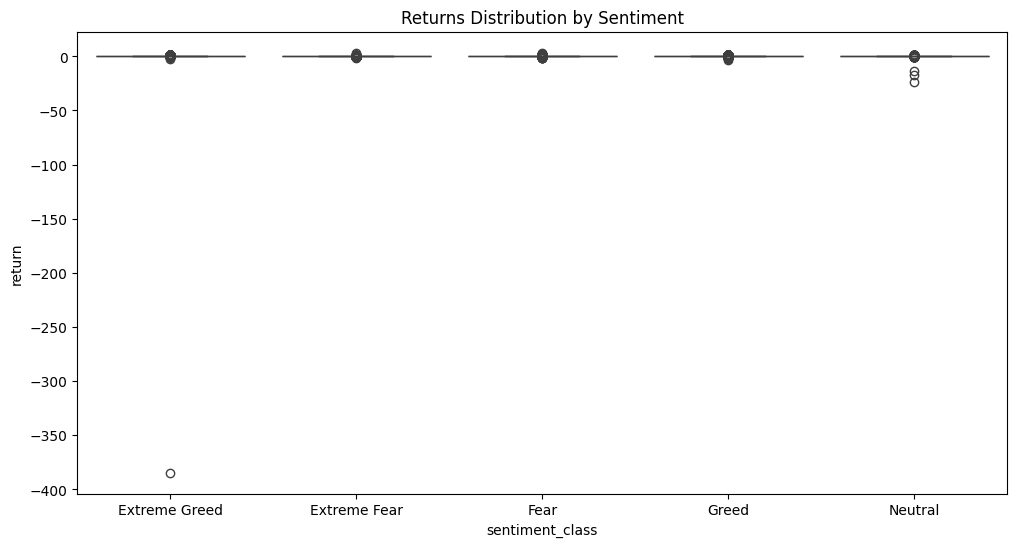

Mean PnL by Sentiment:
 sentiment_class
Extreme Fear     34.985811
Extreme Greed    69.847228
Fear             54.966852
Greed            43.915142
Neutral          34.854311
Name: Closed PnL, dtype: float64
Win Rate by Sentiment:
 sentiment_class
Extreme Fear     0.375414
Extreme Greed    0.478327
Fear             0.426010
Greed            0.395376
Neutral          0.403316
Name: is_win, dtype: float64


In [176]:
os.makedirs("/content/drive/MyDrive/ds_devpratap/outputs", exist_ok=True)


fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='sentiment_class', y='leverage', data=merged, ax=ax)
ax.set_title("Average Leverage by Sentiment")
fig.savefig("/content/drive/MyDrive/ds_devpratap/outputs/avg_leverage_barplot.png", bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='sentiment_class', y='return', data=merged, ax=ax)
ax.set_title("Returns Distribution by Sentiment")
fig.savefig("/content/drive/MyDrive/ds_devpratap/outputs/returns_distribution_boxplot.png", bbox_inches='tight')
plt.show()

print("Mean PnL by Sentiment:\n", merged.groupby('sentiment_class')['Closed PnL'].mean())
print("Win Rate by Sentiment:\n", merged.groupby('sentiment_class')['is_win'].mean())
